This is a work in progress.

Future items to explore:

    cupy

    multiprocessing numpy/scipy with Ray package

    pdal.filter.outlier/elm instead of first part 

    pdal.filter.splitter/merge for large point clouds



In [2]:
from scipy import ndimage, signal, spatial, interpolate
from scipy.ndimage import morphology

import numpy as np
import pandas as pd
import pdal

import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
from osgeo import gdal
raster = gdal.Open(r"E:\IG\ctc_msimbazi.tif")
band1 = raster.GetRasterBand(1) # Red channel
band2 = raster.GetRasterBand(2) # Green channel
band3 = raster.GetRasterBand(3) # Blue channel
b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()
img = np.dstack((b1, b2, b3))
#f = plt.figure(figsize=(10,10))

#plt.imshow(img)
#plt.show()

orthophoto for visual reference only

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
data_in = r"E:\IG\cropped_thinned_cropped.las"

#readin in full res .las , subsampled with Poisson, change radius to reach desired resolution
p = pdal.Reader.las(data_in).pipeline()
n_points = p.execute()
f'Pipeline selected {n_points} points'

'Pipeline selected 5173 points'

In [6]:
#create a one dimensional array from the "Classification" column
cls = p.arrays[0]['Classification']
#set the array to all ones
cls.fill(1)

In [7]:
#convert X,Y, and Z data to a pandas dataframe
df3D = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

In [8]:
#define variables (if we keep k = 0, then I'll clean up the code, remove gstar?)
S = 20
k = 0.000
n = 0.1
b = -0.2

In [9]:
#can't find any documentation on .ptp(), but it must be the x and y length for computing the area
density = n_points / (p.arrays[0]['Y'].ptp() * p.arrays[0]['X'].ptp())
#hres = 1. / density
#override calculated hres and setting it to 0.25 m

#this setting should be relative to point density, but the above method "1./density" is not the way to go.

hres = 1

In [10]:
print("Point cloud density estimated as", density, "pts/m^2. Processing at", hres, "m resolution.")

Point cloud density estimated as 1.2515711951918727 pts/m^2. Processing at 1 m resolution.


In [11]:
dfvis = pd.DataFrame(p.arrays[0])

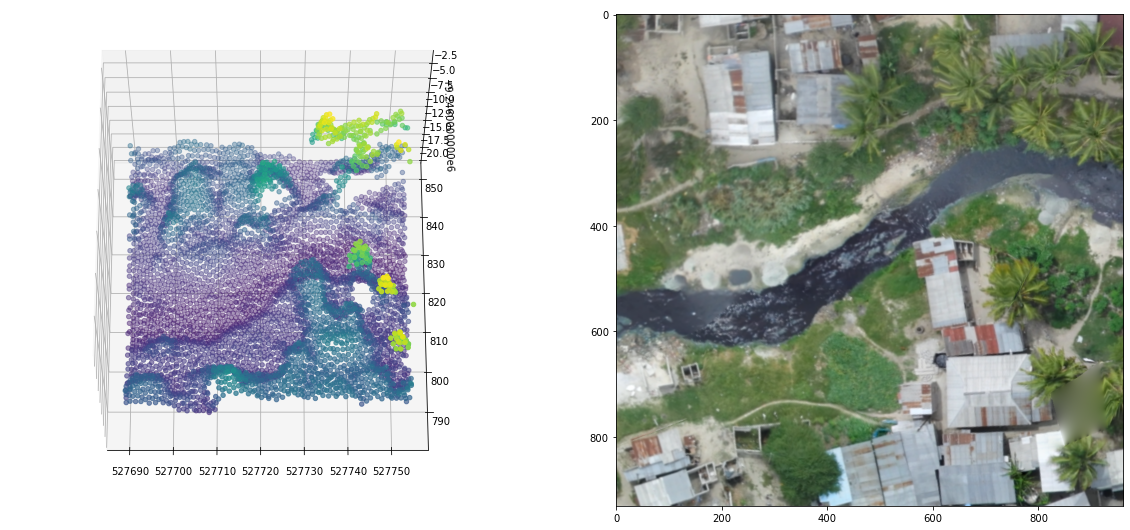

In [12]:
fig = plt.figure(figsize=(20,10))
#plt.subplot(1,2,1)
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(dfvis.X, dfvis.Y, dfvis.Z, c=dfvis.Z, cmap='viridis')
ax.view_init(65, 270)
ax.axis('tight')
plt.subplot(1,2,2)
plt.imshow(img)
#plt.show()

In [13]:
#np.ogrid "open-grid", creates a way to index the matrix (access pixels/pts) hres is the step
xi = np.ogrid[p.arrays[0]['X'].min():p.arrays[0]['X'].max():hres]
yi = np.ogrid[p.arrays[0]['Y'].min():p.arrays[0]['Y'].max():hres]

In [14]:
#np.digitize allocates points to bins and then bins are grouped in the df
bins = df3D.groupby([np.digitize(p.arrays[0]['X'], xi), np.digitize(p.arrays[0]['Y'], yi)])

In [15]:
#figure out a way to plot pointcloud based on group coloring

gb = bins.groups
gb

{(1, 1): [5142], (1, 3): [5143, 5144, 5145], (1, 4): [5146], (1, 5): [5147, 5148], (1, 7): [5149], (1, 8): [5150], (1, 9): [5151], (1, 11): [5152], (1, 12): [5153], (1, 15): [5154], (1, 17): [5155], (1, 21): [5156], (1, 22): [5157], (1, 24): [5158], (1, 25): [5159], (1, 27): [5160], (1, 28): [5161], (1, 30): [5162], (1, 32): [5163], (1, 33): [5164], (1, 35): [5165], (1, 36): [5166], (1, 37): [5167], (1, 39): [5168], (1, 40): [5169], (1, 41): [5170], (1, 44): [5171], (1, 46): [5172], (1, 49): [1065], (1, 50): [1064], (1, 51): [1071], (1, 52): [1062, 1073], (1, 53): [1059, 1072], (1, 54): [1056, 1074], (1, 55): [1057], (1, 56): [1067], (1, 57): [1066], (1, 58): [1069], (1, 59): [1061, 1063], (1, 60): [1070], (1, 61): [1060], (1, 62): [1068], (1, 63): [1058], (2, 1): [266], (2, 2): [311, 350], (2, 3): [382], (2, 4): [416, 432], (2, 5): [474, 513], (2, 6): [531, 573], (2, 7): [601, 657], (2, 8): [702], (2, 9): [769], (2, 10): [829], (2, 11): [865, 899], (2, 12): [933], (2, 13): [1312, 1372

In [16]:
zmins = bins.Z.min() #collects the lowest point in each bin
cz = np.empty((yi.size, xi.size)) #create empty 2d array 
cz.fill(np.nan) #fill 2d array with nan
for name, val in zmins.items():
    #print(name[1],name[0],val)
    cz[name[1]-1, name[0]-1] = val #adding coordinates to lowest points only(not sure why -1 is used here)

In [17]:
x,y =cz.shape
x,y,hres

major = np.arange(0,x,hres*10)
minor = np.arange(0,x,hres)

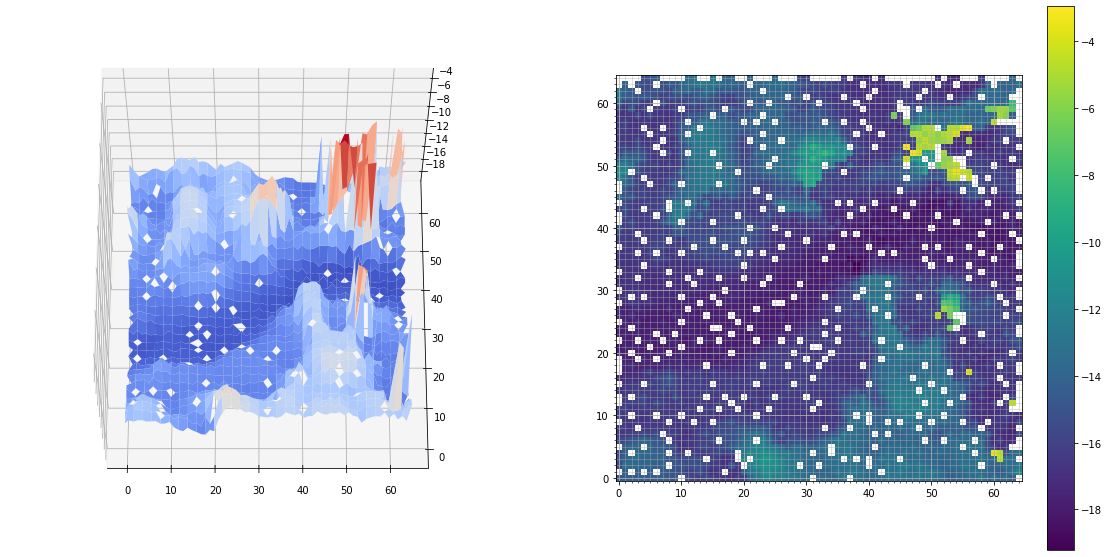

In [18]:
fig= plt.figure(figsize=(20,10))

nx,ny =cz.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 270)
ax.plot_surface(X,Y,cz,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

In [19]:
def idw(data):
    # Find indices of the ground returns, i.e., anything that is not a nan, and create a KD-tree.
    # We will search this tree when looking for nearest neighbors to perform the interpolation.
    valid = np.argwhere(~np.isnan(data))
    tree = spatial.cKDTree(valid)
    
    # Now find indices of the non-ground returns, as indicated by nan values. We will interpolate
    # at these locations.
    nans = np.argwhere(np.isnan(data))    
    for row in nans:
        d, idx = tree.query(row, k=12)
        d = np.power(d, -2)
        v = data[valid[idx, 0], valid[idx, 1]]
        data[row[0], row[1]] = np.inner(v, d)/np.sum(d)
        
    return data

In [20]:
%%time
cz = idw(cz)

Wall time: 20.5 ms


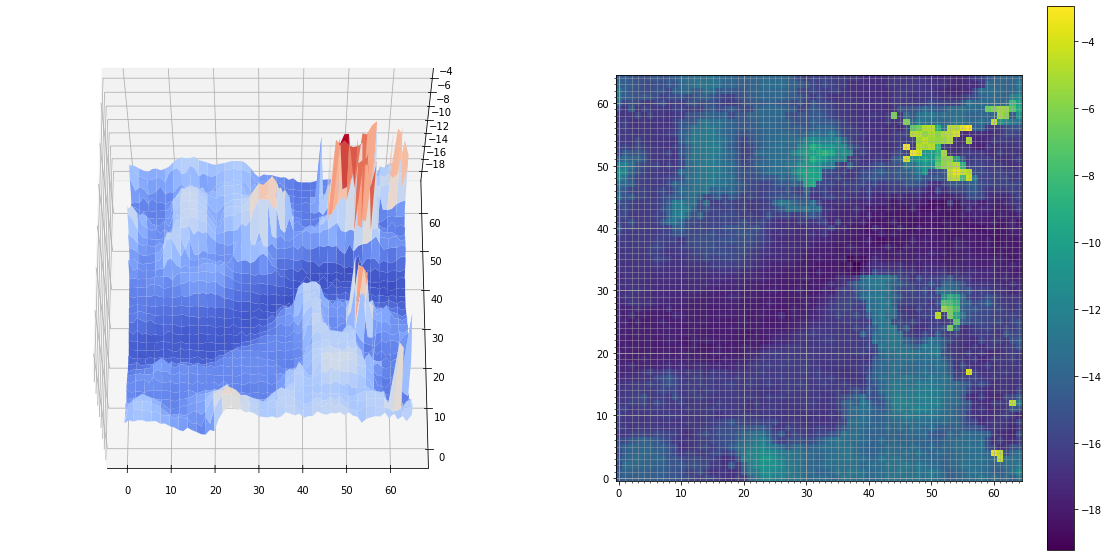

In [21]:
fig= plt.figure(figsize=(20,10))

nx,ny =cz.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 270)
ax.plot_surface(X,Y,cz,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

#Stage 1: Remove Low Outliers

https://www.youtube.com/watch?v=E_vU1Wd7Ks8&ab_channel=JianWeiTay

In [22]:
#create an initial diamond structure 2,1 and enlarge it 11 times = 23x,23y
#does this structoring element size have any corelation to point density,cloud features or binsize?

struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
opened = morphology.grey_opening(cz, structure=struct) #opening = Erosion -> Dilation

#morphological opening is useful to smooth objects and remove noise

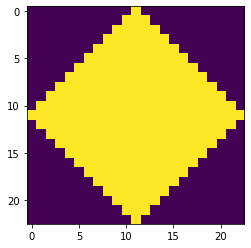

In [23]:
plt.imshow(struct)

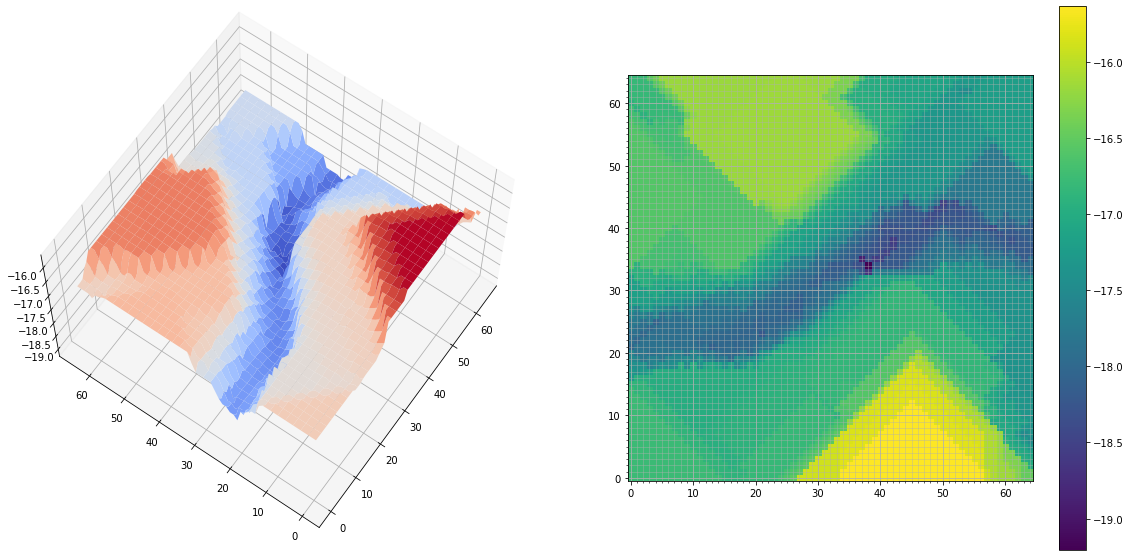

In [24]:
fig= plt.figure(figsize=(20,10))

nx,ny =opened.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 215)
ax.plot_surface(X,Y,opened,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(opened, origin='lower'); plt.colorbar(); ax.grid()

In [25]:
#create another plus-shaped (2,1) and enlarge it 9 times = 19x,19y
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
closed = morphology.grey_closing(opened, structure=struct) #closing = dilation -> erosion

#closing is useful for filling in small holes while preserving shape and size of objects

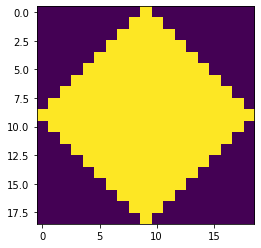

In [26]:
plt.imshow(struct)

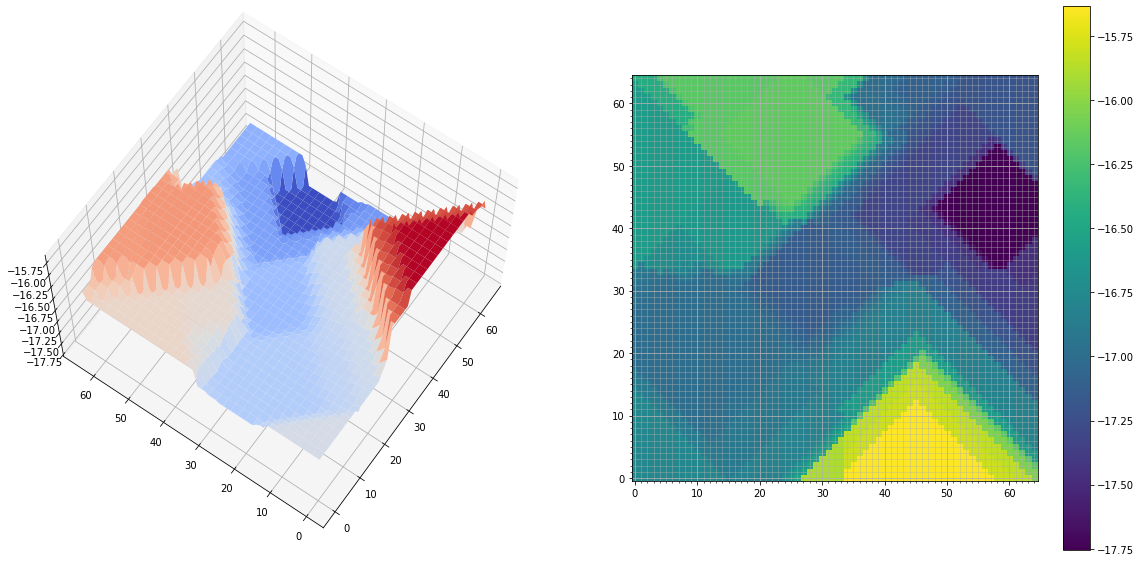

In [27]:
fig= plt.figure(figsize=(20,10))

nx,ny =closed.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 215)
ax.plot_surface(X,Y,closed,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(closed, origin='lower'); plt.colorbar(); ax.grid()

In [28]:
#removing low outliers: if any pt in cz is >= 1 meter below the surface of closed then it is set to the 
#closed surface value
#need to test lower limit >= 0.5
lowx, lowy = np.where((closed - cz) >= 1.0) 
cz[lowx, lowy] = closed[lowx, lowy]

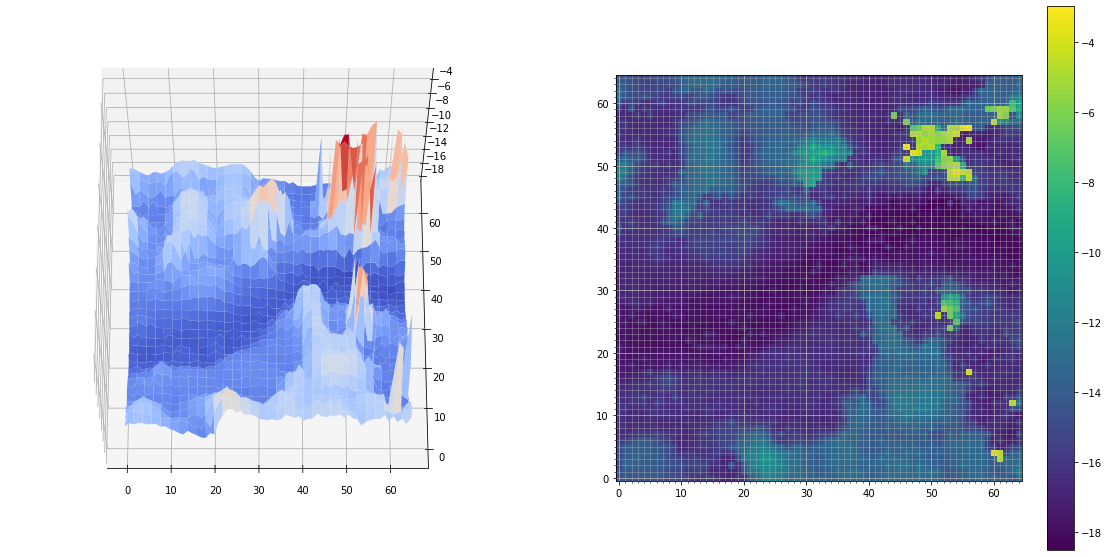

In [29]:
fig= plt.figure(figsize=(20,10))

nx,ny =cz.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 270)
ax.plot_surface(X,Y,cz,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(cz, origin='lower'); plt.colorbar(); ax.grid()

#Stage 2: Filter Points

fftconvolve vs convolve https://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html

"fftconvolve is only faster if you have two long arrays to convolve" joep taken from:https://groups.google.com/g/scipy-user/c/_s5H5Ibra50

I could certainly run my own tests

multiprocessing numpy/scipy with Ray https://stackoverflow.com/questions/55623192/python-multiprocessing-slow-with-numpy-scipy https://docs.ray.io/en/latest/

could also use cupy

In [30]:
stdev = 14

#product of two guassian arrays with the max normalized to 1, size/window = 113
#the size of the gaussian kernel must be large enough to remove all non-ground features (bigger than the largest building)
#should kernel size be scaled to bin size? Current kernel size works great with 1 meter bin
#.5m bin should have 226 kernel? .25m bin / 452? would also need to increase stdev with bigger kernel

G = np.outer(signal.gaussian(113,stdev), signal.gaussian(113,stdev))

#fast fourier transform convolution, matrix is padded at 2*stdev
low = signal.fftconvolve(np.pad(cz,2*stdev,'edge'), G, mode='same')[2*stdev:-2*stdev,2*stdev:-2*stdev]/1000.

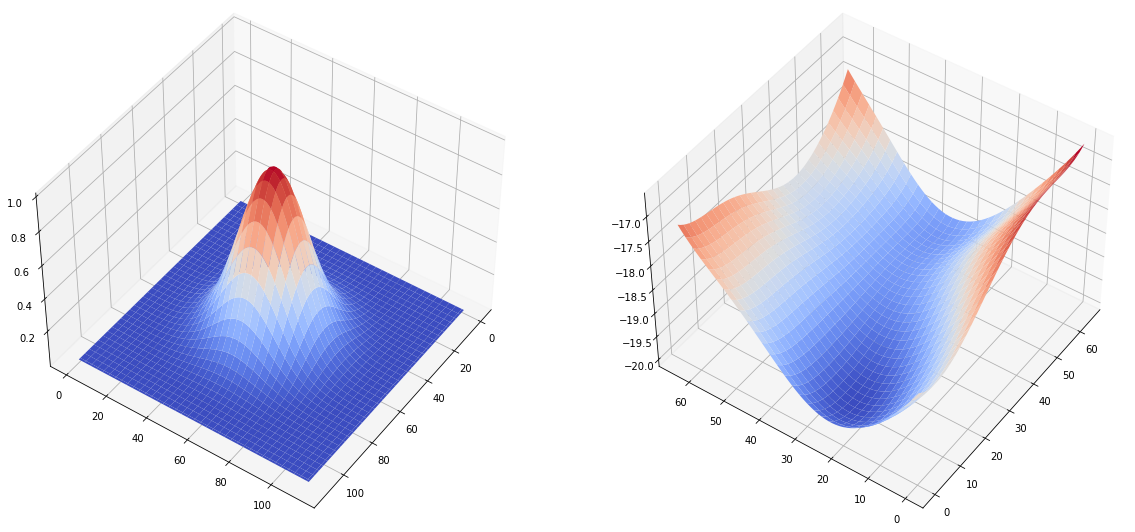

In [31]:
nx,ny =G.shape
x = range(nx)
y = range(ny)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')

X,Y = np.meshgrid(x,y)
ax.view_init(45, 35)
ax.plot_surface(X,Y,G,cmap=cm.coolwarm)

nx,ny =cz.shape
x = range(nx)
y = range(ny)

ax = fig.add_subplot(1,2,2, projection='3d')

X,Y = np.meshgrid(x,y)
ax.view_init(45, 215)
ax.plot_surface(X,Y,low,cmap=cm.coolwarm)

In [32]:
%%time
high = cz - low

Wall time: 0 ns


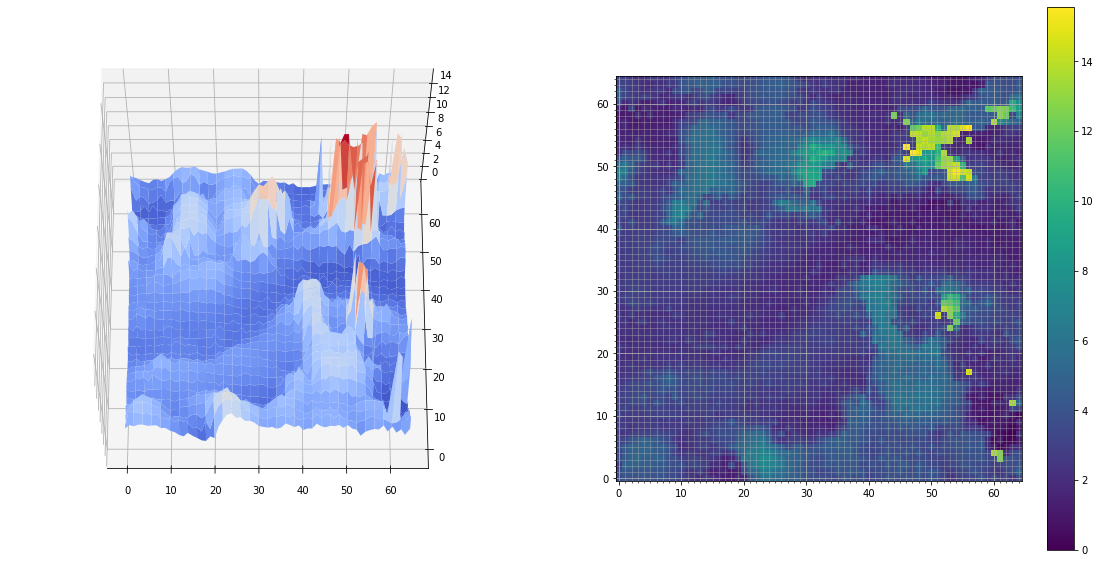

In [33]:
fig= plt.figure(figsize=(20,10))

nx,ny =high.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 270)
ax.plot_surface(X,Y,high,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(high, origin='lower'); plt.colorbar(); ax.grid()

flattening structure defined by size=3

 https://www.mathworks.com/help/images/structuring-elements.html#:~:text=A%20flat%20structuring%20element%20is,in%20the%20image%20being%20processed.

greyscale erosion: https://en.wikipedia.org/wiki/Erosion_%28morphology%29, https://www.youtube.com/watch?v=yM0tqRhpxoM&ab_channel=JianWeiTay

In [34]:
%%time
#size 3 = 3 x 3 flat and full structuring element

erosions = []
granulometry = []
erosions.append(morphology.grey_erosion(high, size=3))

#trying to come up with a way to visualize the grey erosion on high
nper = np.asarray(erosions)
nper.shape
x,y = high.shape
new = nper.reshape(x,y)

Wall time: 504 µs


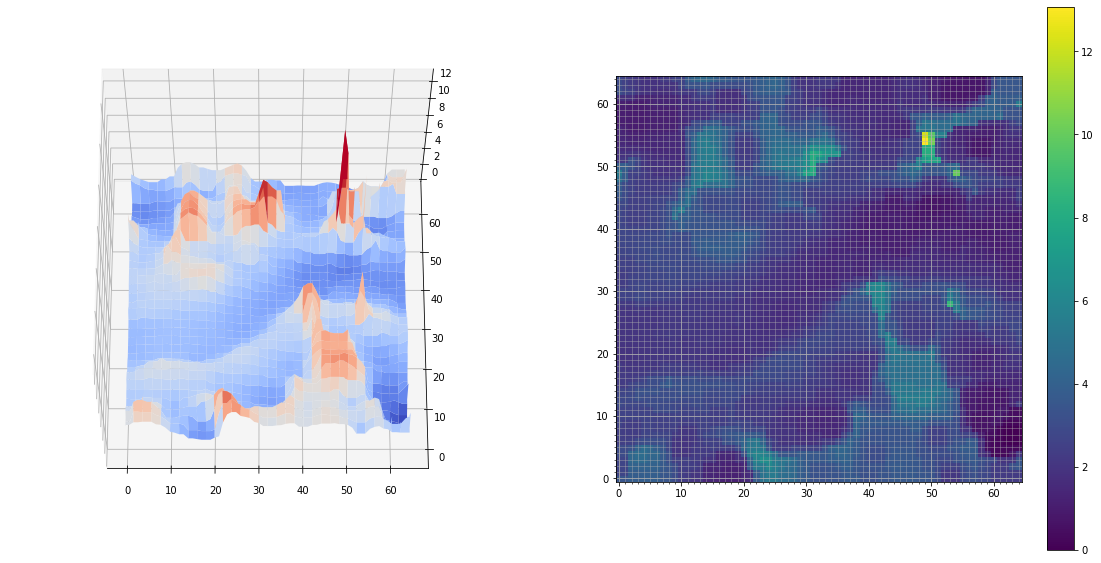

In [35]:
fig= plt.figure(figsize=(20,10))

nx,ny =new.shape
x = range(nx)
y = range(ny)

#hf = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
X,Y = np.meshgrid(x,y)
ax.view_init(65, 270)
ax.plot_surface(X,Y,new,cmap=cm.coolwarm)

ax = fig.add_subplot(1,2,2)
ax.set_xticks(minor,minor=True)
ax.set_yticks(minor,minor=True)
ax.grid(which='minor', alpha=0.5)
plt.imshow(new, origin='lower'); plt.colorbar(); ax.grid()

In [36]:
for scale in range(1, S):
    erosions.append(morphology.grey_erosion(erosions[scale-1], size=3))
for scale in range(1, S+1):
    granulometry.append(morphology.grey_dilation(erosions[scale-1], size=2*scale+1))

In [37]:
%%time
out = []
for i in range(1, len(granulometry)):
    out.append(granulometry[i-1]-granulometry[i])

Wall time: 500 µs


In [38]:
%%time
gprime = np.maximum.reduce(out)
xs, ys = out[0].shape
gstar = np.zeros((xs,ys))
gplus = np.zeros((xs,ys))
for ii in range(0,xs):
    for jj in range(0,ys):
        for kk in range(0,len(out)):
            if out[kk][ii,jj] < gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
            if out[kk][ii,jj] == gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
                gstar[ii,jj] = kk
                break

Wall time: 27.5 ms


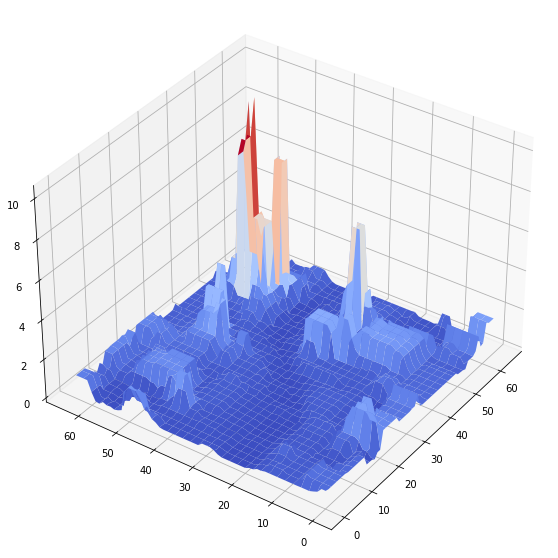

In [39]:
nx,ny =gprime.shape
x = range(nx)
y = range(ny)


hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,gprime,cmap=cm.coolwarm)

Text(0.5, 1.0, '$g^+$')

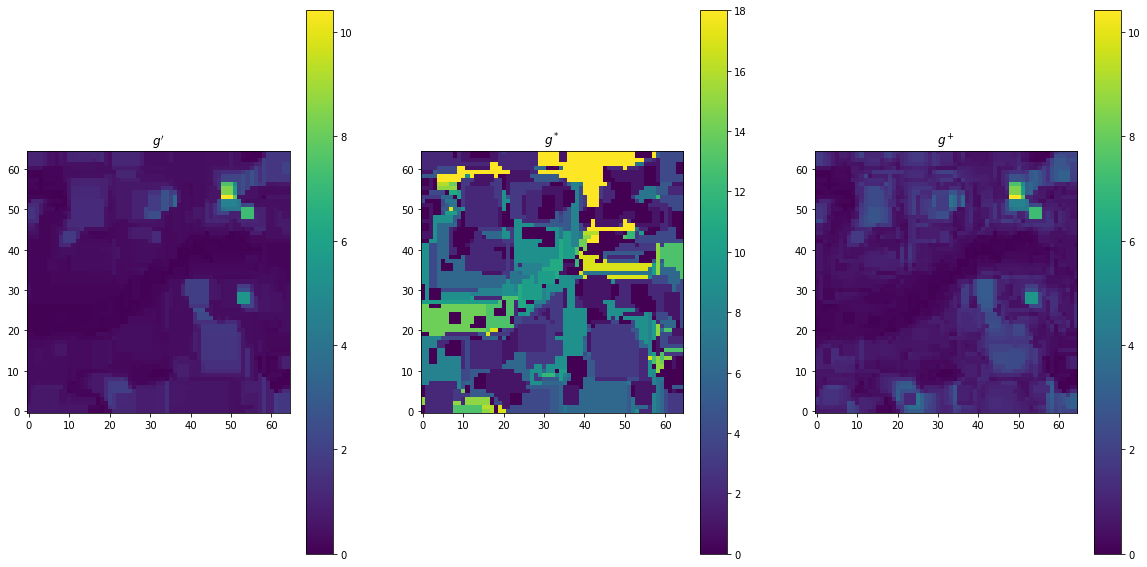

In [40]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(gprime, origin='lower'); plt.colorbar(); plt.title('$g^{\prime}$')
plt.subplot(1,3,2); plt.imshow(gstar, origin='lower'); plt.colorbar(); plt.title('$g^*$')
plt.subplot(1,3,3); plt.imshow(gplus, origin='lower'); plt.colorbar(); plt.title('$g^+$')

In [41]:
T = k * gstar + n
Sg = gprime < n

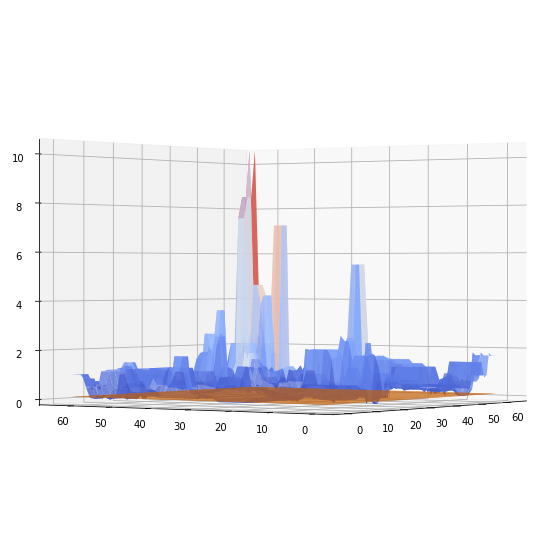

In [42]:
nx,ny =gprime.shape
x = range(nx)
y = range(ny)
hs = np.ones((nx,ny))
hs.fill(n)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(0, 215)
ha.plot_surface(X,Y,gprime,cmap=cm.coolwarm,alpha=0.75)
ha.plot_surface(X,Y,hs,alpha=1)

In [112]:
F = cz.copy()
F[np.where(Sg==0)] = np.nan

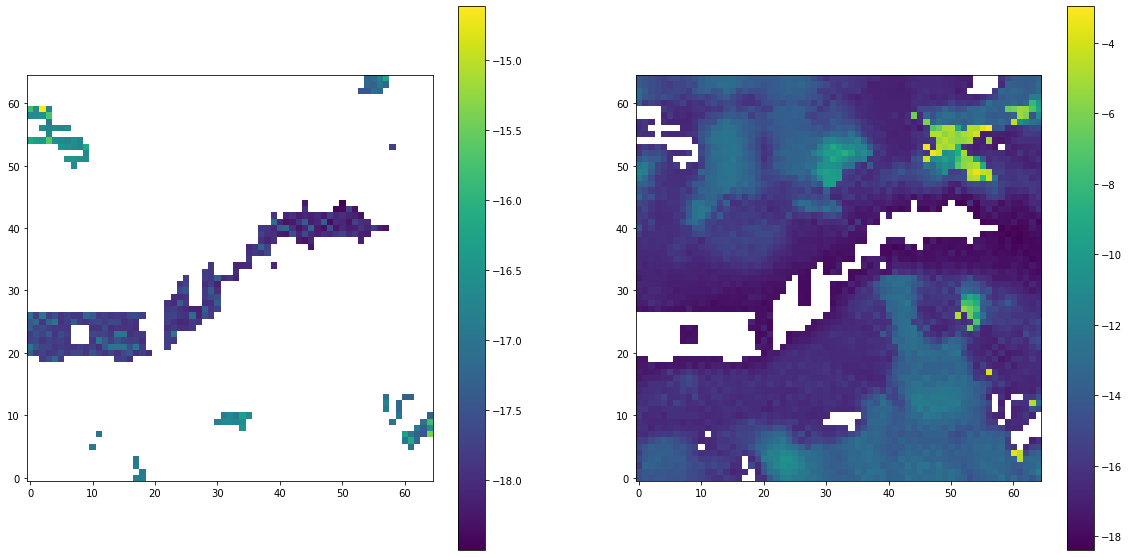

In [113]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.imshow(F, origin='lower'); plt.colorbar();
nonGround = cz.copy()
nonGround[np.where(Sg==1)] = np.nan
plt.subplot(1,2,2); plt.imshow(nonGround, origin='lower'); plt.colorbar();

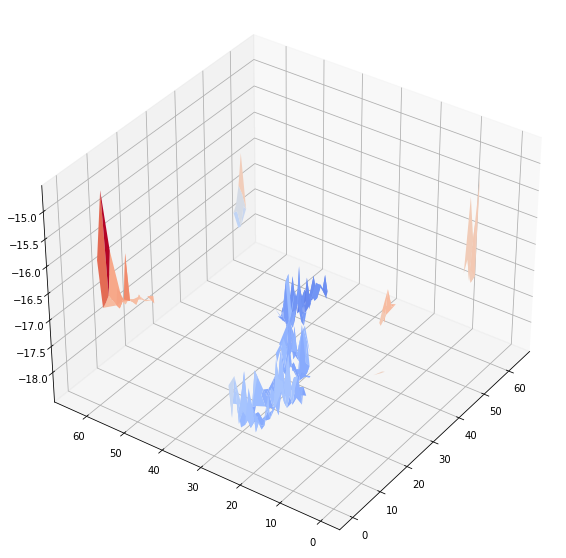

In [114]:
nx,ny =F.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,F,cmap=cm.coolwarm)

In [46]:
G = idw(F)

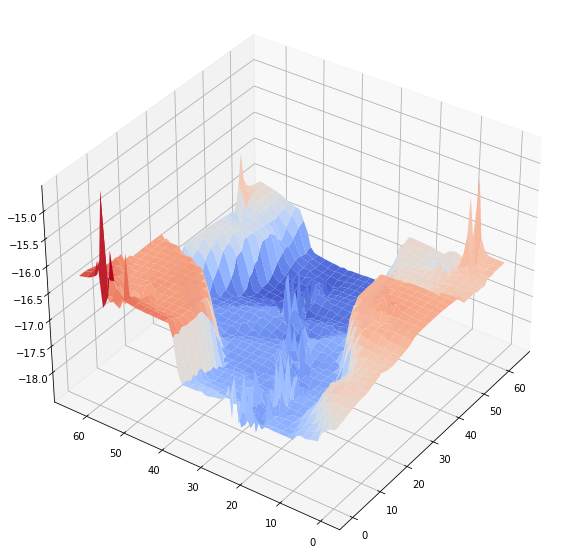

In [47]:
nx,ny =G.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,G,cmap=cm.coolwarm)

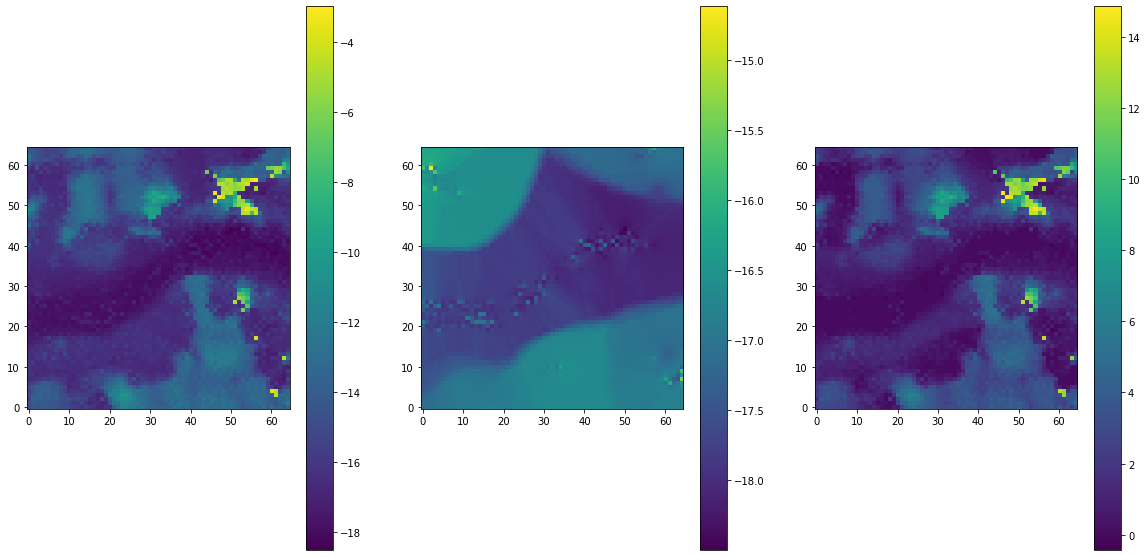

In [48]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(G, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-G, origin='lower'); plt.colorbar();

In [49]:
#need to test increasing the size of the structure element here - might improve river bank selection

%%time
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
gradDTM = morphology.grey_dilation(G, structure=struct)

Wall time: 501 µs


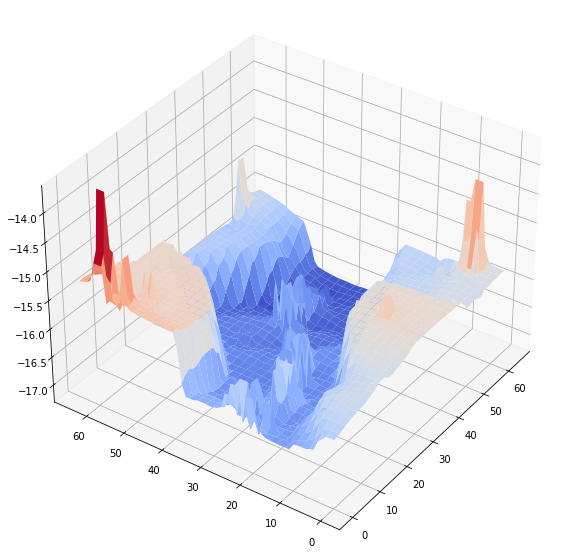

In [50]:
nx,ny =gradDTM.shape
x = range(nx)
y = range(ny)

hf = plt.figure(figsize=(20,10))
ha = hf.add_subplot(111, projection='3d')

X,Y = np.meshgrid(x,y)
ha.view_init(35, 215)
ha.plot_surface(X,Y,gradDTM,cmap=cm.coolwarm)

research scipy.interpolate.griddata

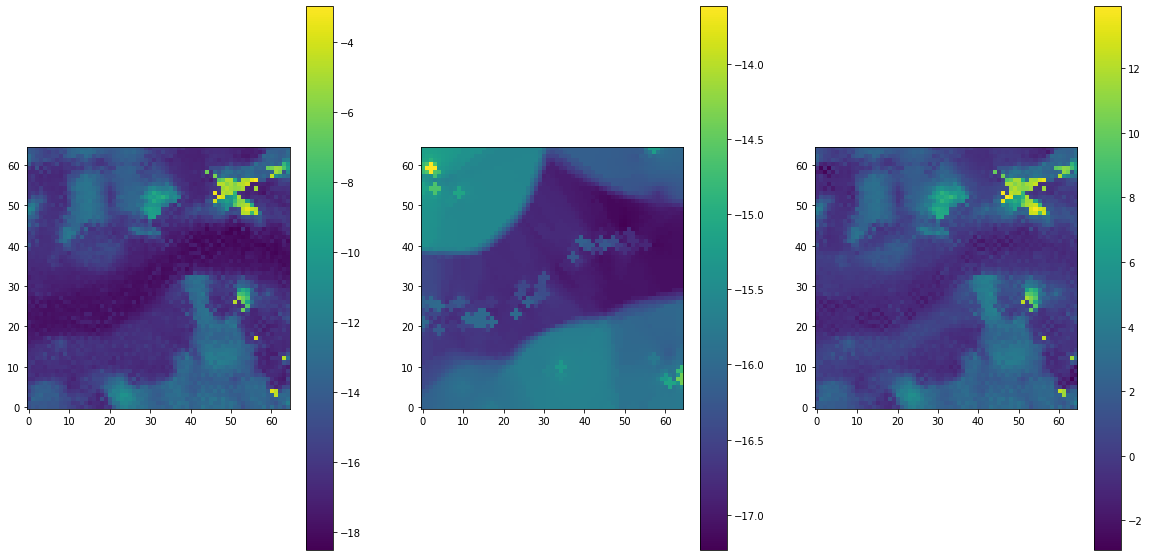

In [53]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(gradDTM, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-(gradDTM+b), origin='lower'); plt.colorbar();

In [54]:
%%time
xbins = np.digitize(df3D.X, xi)
ybins = np.digitize(df3D.Y, yi)
nonground = np.where(df3D.Z >= gradDTM[ybins-1, xbins-1]+b)
ground = np.where(df3D.Z < gradDTM[ybins-1, xbins-1]+b)

Wall time: 973 µs


In [55]:
print("Detected", len(ground[0]), "ground and", len(nonground[0]), "non-ground points")

Detected 1587 ground and 3586 non-ground points


In [56]:
%%time
g = df3D.iloc[ground]
ng = df3D.iloc[nonground]

Wall time: 1e+03 µs


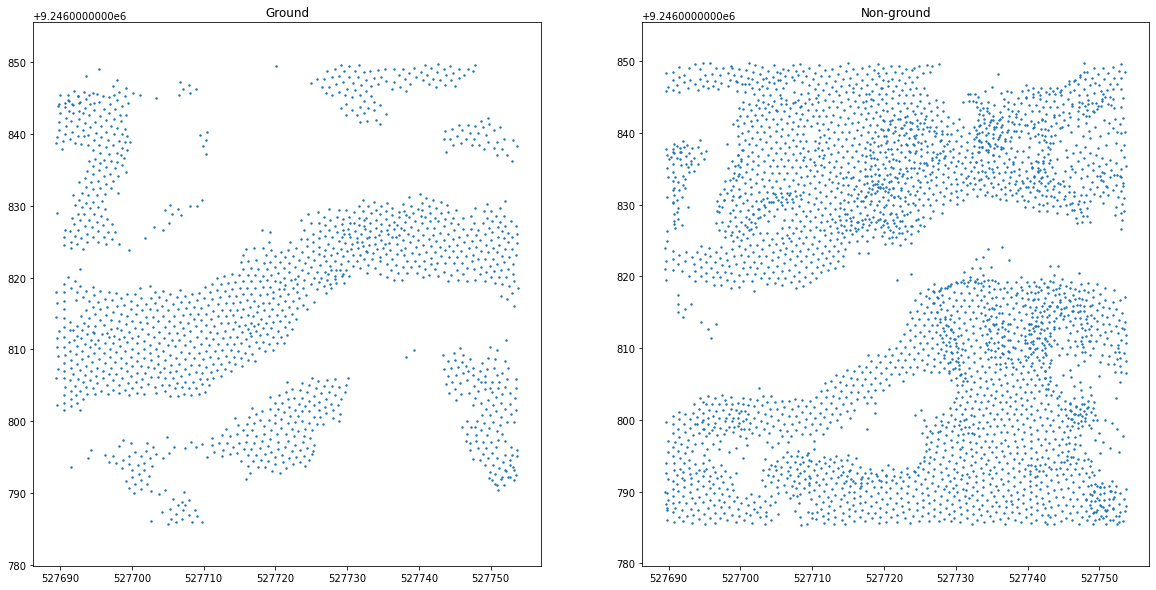

In [57]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.scatter(g.X, g.Y, s=2); plt.title('Ground'); plt.axis('equal');
plt.subplot(1,2,2); plt.scatter(ng.X, ng.Y, s=2); plt.title('Non-ground'); plt.axis('equal');

In [100]:
#fig = plt.figure(figsize=(20,10))

#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(g.X, g.Y, g.Z, c=g.Z, cmap='viridis')
#ax.view_init(45, 195)

#ax.axis('tight')

In [108]:
x = np.asarray(g.X)
y = np.asarray(g.Y)
z = np.asarray(g.Z)

In [109]:
tri = spatial.Delaunay(np.array([x,y]).T)

In [99]:
#fig = plt.figure(figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.view_init(45,205)
#ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=cm.coolwarm)


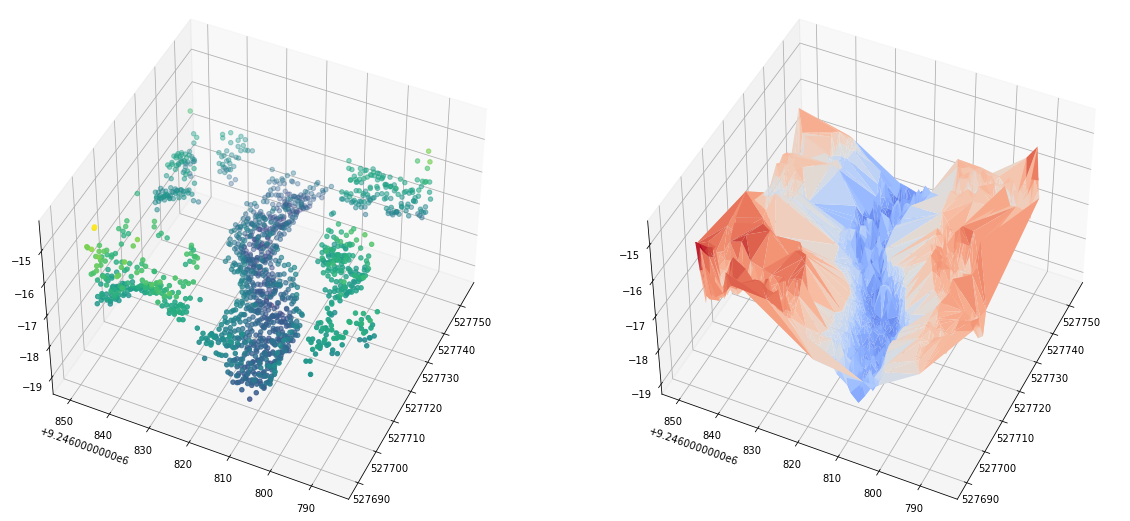

In [110]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1, projection='3d')

ax.scatter(g.X, g.Y, g.Z, c=g.Z, cmap='viridis')
ax.view_init(45, 205)

ax.axis('tight')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.view_init(45,205)
ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=cm.coolwarm)

In [59]:
cls[ground] = 2 #set ground points to 2
len(cls[ground]) #number of ground points

1587

In [60]:
output = p.arrays[0]
output['Classification'] =cls

#Stage 3: Filter again with PMF

In [90]:
#include only ground points
pipeline = pdal.Filter.range(limits="Classification[2:2]").pipeline(output)
print(pipeline.execute())

1587


In [91]:
#default Progressive morphological filter stacked to catch stragglers (havent'tested with alt parameters)
#need to test with alt smrf
pmf_arr = pipeline.arrays[0]
p = pdal.Filter.pmf().pipeline(pmf_arr) | pdal.Filter.range(limits="Classification[2:2]").pipeline()
print(p.execute())

1151


In [92]:
#convert X,Y, and Z data to a pandas dataframe
dfvis2 = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

In [104]:
#fig = plt.figure(figsize=(20,10))

#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(dfvis2.X, dfvis2.Y, dfvis2.Z, c=dfvis2.Z, cmap='viridis')
#ax.view_init(45, 195)

#ax.axis('tight')

In [94]:
x = np.asarray(dfvis2.X)
y = np.asarray(dfvis2.Y)
z = np.asarray(dfvis2.Z)

In [95]:
tri = spatial.Delaunay(np.array([x,y]).T)

In [103]:
#fig = plt.figure(figsize=(20,20))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.view_init(45,205)
#ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=cm.coolwarm)

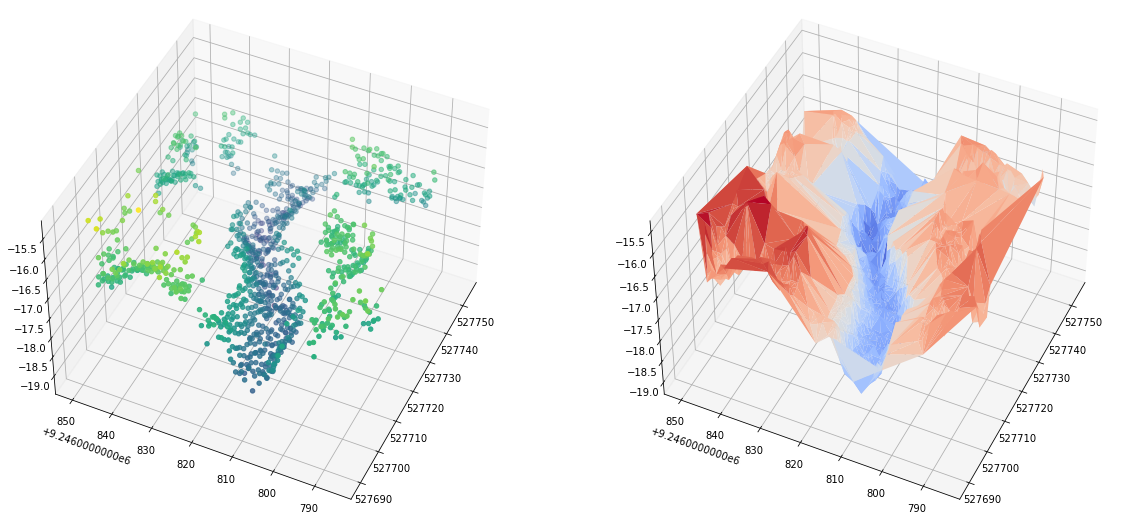

In [106]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1, projection='3d')

ax.scatter(dfvis2.X, dfvis2.Y, dfvis2.Z, c=dfvis2.Z, cmap='viridis')
ax.view_init(45, 205)

ax.axis('tight')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.view_init(45,205)
ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=cm.coolwarm)